In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Load the dataset
data = pd.read_csv('WorldCupShootouts.csv')

# Display the first few rows of the dataset
print(data.head())

print('\nDataset Columns:', data.columns)

   Game_id Team  Zone Foot Keeper  OnTarget  Goal  Penalty_Number  Elimination
0        1  FRA   7.0    R      R       1.0   1.0               1          0.0
1        1  GER   9.0    R      C       1.0   1.0               2          0.0
2        1  FRA   6.0    R      L       1.0   1.0               3          0.0
3        1  GER   2.0    R      C       1.0   1.0               4          0.0
4        1  FRA   9.0    R      L       1.0   1.0               5          0.0

Dataset Columns: Index(['Game_id', 'Team', 'Zone', 'Foot', 'Keeper', 'OnTarget', 'Goal',
       'Penalty_Number', 'Elimination'],
      dtype='object')


In [5]:
# Feature Engineering

data['High_Pressure'] = ((data['Elimination'] == 1) | (data['Penalty_Number'] >= 5)).astype(int)    # High pressure if elimination or penalty number >= 5

data['Team_Clutch_Performance'] = np.where(
    (data['High_Pressure'] == 1) & (data['Goal'] == 1), 1,
    np.where((data['High_Pressure'] == 1) & (data['Goal'] == 0), 0, np.nan)
)       # Clutch performance in high-pressure situations

data_clutch = data[data['Team_Clutch_Performance'].notna()].copy()  # Filter out rows with NaN in 'Team_Clutch_Performance'

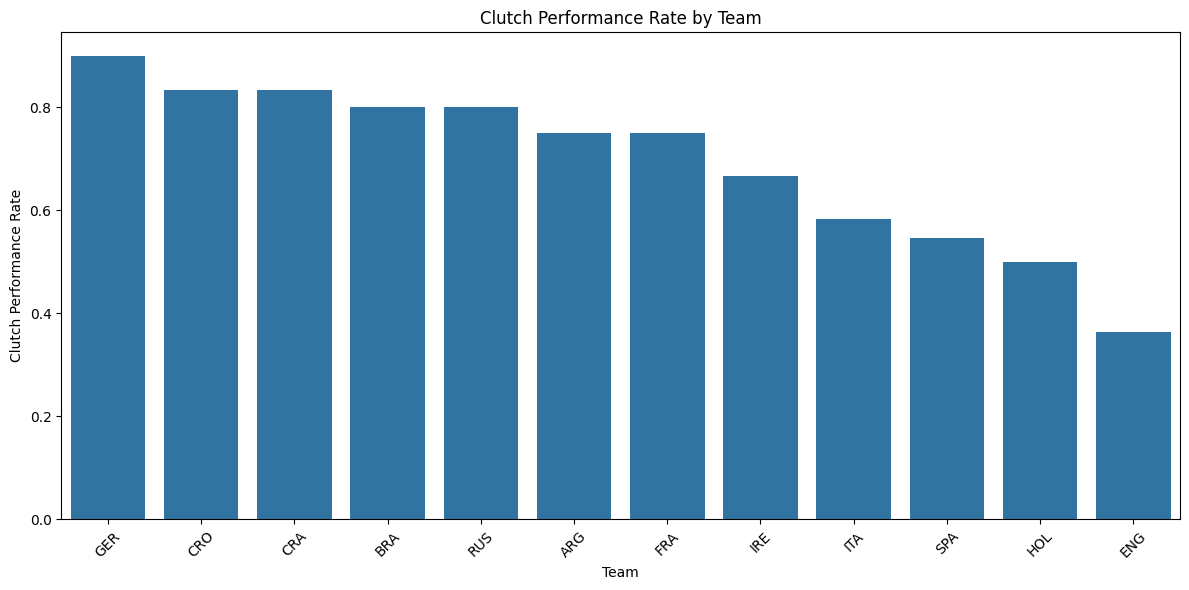

In [ ]:
team_stats = data_clutch.groupby('Team')['Team_Clutch_Performance'].agg(['mean', 'count']).reset_index()  # Calculate clutch performance rate and total penalties
team_stats.columns = ['Team', 'Clutch_Performance_Rate', 'Total_Penalties']    # Rename columns for clarity

filtered_teams = team_stats[team_stats['Total_Penalties'] >= 5].sort_values(by='Clutch_Performance_Rate', ascending=False)  # Filter teams with at least 5 penalties, using data only that's statistically significant
clutch_rate = filtered_teams.set_index('Team')['Clutch_Performance_Rate']
plt.figure(figsize=(12, 6))
sns.barplot(x=clutch_rate.index, y=clutch_rate.values)
plt.xticks(rotation=45)
plt.title('Clutch Performance Rate by Team')
plt.xlabel('Team')
plt.ylabel('Clutch Performance Rate')
plt.tight_layout()
plt.show()

In [8]:
features = ['Team', 'Zone', 'Foot', 'Keeper', 'Penalty_Number']
X = data_clutch[features]       # Features for the model
y = data_clutch['Team_Clutch_Performance']      # Target variable

X_encoded = pd.get_dummies(X, columns=['Team', 'Zone', 'Foot', 'Keeper'], drop_first=True)  # One-hot encode categorical variables

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize the model
clf.fit(X_train, y_train)  # Train the model

y_pred = clf.predict(X_test)  # Make predictions on the test set

# Evaluate the model
print('\nClassification Report:')
print(classification_report(y_test, y_pred))  # Print classification report
print('\nConfusion matrix: ', confusion_matrix(y_test, y_pred))  # Print confusion matrix


Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.27      0.40        11
         1.0       0.71      0.95      0.82        21

    accuracy                           0.72        32
   macro avg       0.73      0.61      0.61        32
weighted avg       0.73      0.72      0.67        32


Confusion matrix:  [[ 3  8]
 [ 1 20]]


In [13]:
# Show some test predictions
test_results = X_test.copy()
test_results['Actual'] = y_test
test_results['Predicted'] = y_pred

print('\nTest Predictions:')
print(test_results.head())


Test Predictions:
     Penalty_Number  Team_BEL  Team_BRA  Team_BUL  Team_CHI  Team_COL  \
7                 8     False     False     False     False     False   
232               9     False      True     False     False     False   
251               8     False     False     False     False     False   
292               9     False     False     False     False      True   
179               6     False     False     False     False     False   

     Team_CRA  Team_CRO  Team_DEN  Team_ENG  ...  Zone_6.0  Zone_7.0  \
7       False     False     False     False  ...     False     False   
232     False     False     False     False  ...     False      True   
251     False     False     False     False  ...     False      True   
292     False     False     False     False  ...     False     False   
179     False     False     False     False  ...     False      True   

     Zone_8.0  Zone_9.0  Foot_R  Keeper_L  Keeper_R  Keeper_l  Actual  \
7       False     False    True     

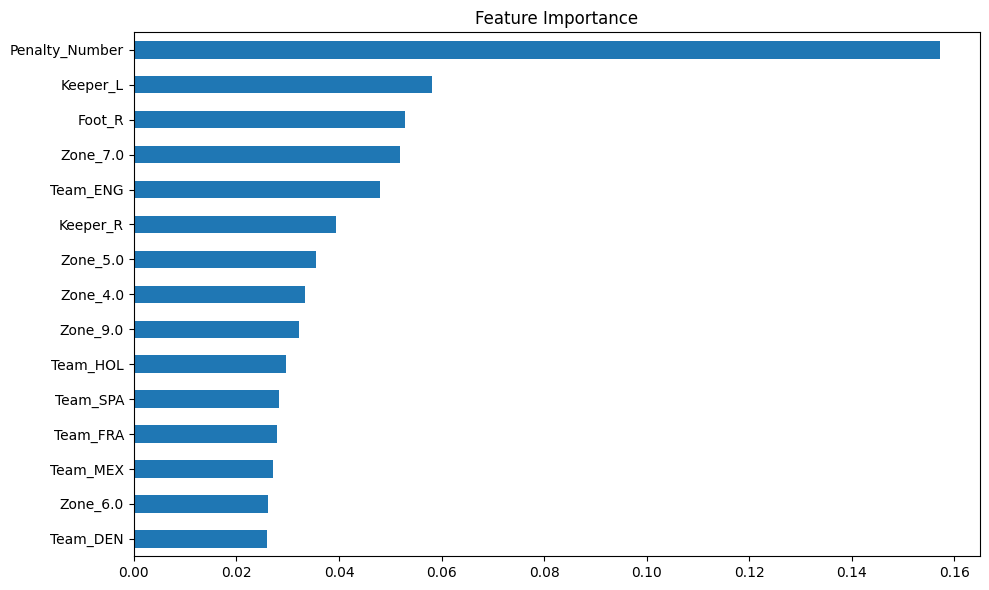

In [11]:
# Feature Importance
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).tail(15).plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()